In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import pandas as pd

In [4]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [5]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 
                         'train_accuracy', 'val_accuracy']] = cv_results[['param_C', 'mean_fit_time', 
                                                                          'mean_train_accuracy', 'mean_test_accuracy']]
    filtered_cv_results['nr_train_sv'] = cv_results['mean_train_nr_support_vectors'].round().astype(int)
    filtered_cv_results['nr_val_sv'] = cv_results['mean_test_nr_support_vectors'].round().astype(int)

    return filtered_cv_results

## Hinge loss

### Primal formulation

In [6]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [7]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y),
            'nr_support_vectors': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


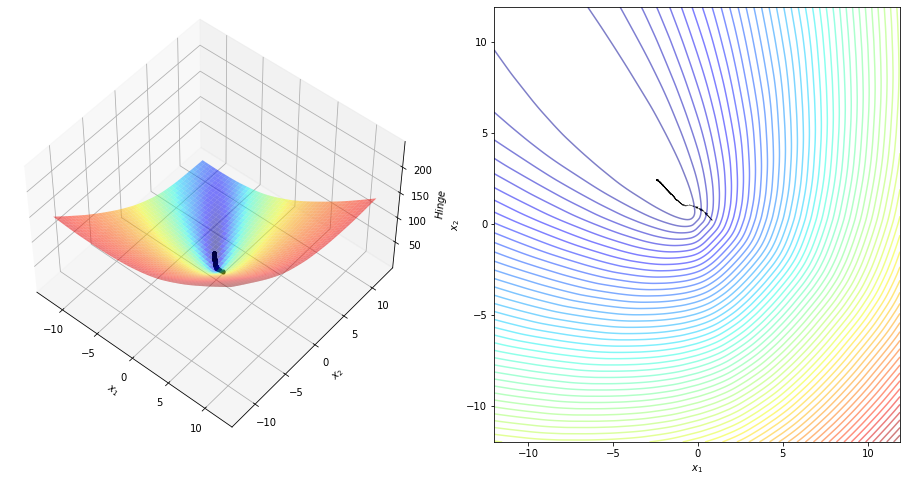

In [22]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_hinge_loss.png')

In [20]:
custom_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_hinge_cv_results.insert(0, 'solver', 'adagrad')
custom_primal_svc_hinge_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
adagrad,1,0.002570,0.990012,0.985075,10,4
adagrad,10,0.003505,0.992500,0.990050,5,2
adagrad,100,0.004878,0.992500,0.990050,4,2


In [21]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [22]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
liblinear,1,0.002726,0.967531,0.960124,13,8
liblinear,10,0.003951,0.970037,0.965099,8,4
liblinear,100,0.005037,0.967549,0.970149,10,3


In [23]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results, ignore_index=True)
primal_svc_hinge_cv_results.sort_values(['C', 'solver'], inplace=True)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_svc_hinge.tex', index=False)
primal_svc_hinge_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
adagrad,1,0.002570,0.990012,0.985075,10,4
liblinear,1,0.002726,0.967531,0.960124,13,8
adagrad,10,0.003505,0.992500,0.990050,5,2
liblinear,10,0.003951,0.970037,0.965099,8,4
adagrad,100,0.004878,0.992500,0.990050,4,2
liblinear,100,0.005037,0.967549,0.970149,10,3


### Dual formulations

In [8]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC as SklSVC
from sklearn.model_selection import GridSearchCV

In [9]:
def dual_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y),
            'nr_support_vectors': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


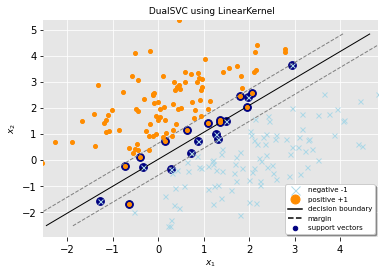

In [10]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/linear_dual_svc_hyperplane.png')

In [27]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
smo,1,0.194799,0.985019,0.980100,11,11
cvxopt,1,0.063277,0.985019,0.980100,11,11
smo,10,0.243180,0.987506,0.975049,6,6
cvxopt,10,0.050291,0.987506,0.980100,7,7
smo,100,0.600229,0.985000,0.975049,6,6
cvxopt,100,0.023014,0.990012,0.980100,6,6


In [28]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SklSVC(kernel='linear'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [29]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
libsvm,1,0.003978,0.980025,0.969998,13,13
libsvm,10,0.004888,0.980006,0.974974,9,9
libsvm,100,0.006158,0.980006,0.969998,8,8


In [31]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results, ignore_index=True)
linear_dual_svc_cv_results.sort_values(['C', 'solver'], inplace=True)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', index=False)
linear_dual_svc_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
cvxopt,1,0.063277,0.985019,0.980100,11,11
libsvm,1,0.003978,0.980025,0.969998,13,13
smo,1,0.194799,0.985019,0.980100,11,11
cvxopt,10,0.050291,0.987506,0.980100,7,7
libsvm,10,0.004888,0.980006,0.974974,9,9
smo,10,0.243180,0.987506,0.975049,6,6
cvxopt,100,0.023014,0.990012,0.980100,6,6
libsvm,100,0.006158,0.980006,0.969998,8,8
smo,100,0.600229,0.985000,0.975049,6,6


##### Nonlinear

Fitting 3 folds for each of 6 candidates, totalling 18 fits


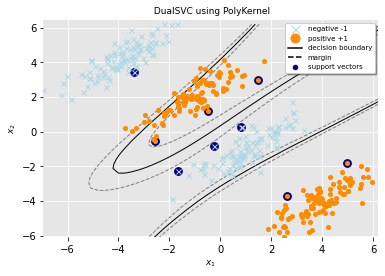

In [12]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/poly_dual_svc_hyperplane.png')

In [13]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results.style.hide_index()

solver,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
smo,poly,1,1.727187,0.894939,0.708506,25,25
cvxopt,poly,1,0.111452,0.914914,0.736075,25,25
smo,poly,10,1.463762,0.883712,0.733345,10,10
cvxopt,poly,10,0.095493,0.881215,0.715913,10,10
smo,poly,100,1.525448,0.936240,0.872854,8,8
cvxopt,poly,100,0.078176,0.928726,0.820615,8,8


Fitting 3 folds for each of 6 candidates, totalling 18 fits


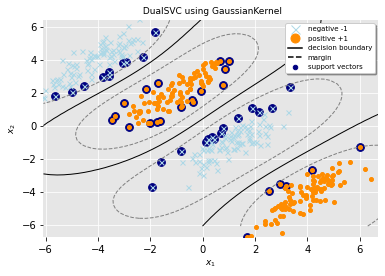

In [15]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/gaussian_dual_svc_hyperplane.png')

In [18]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results.style.hide_index()

solver,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
smo,rbf,1,0.418548,1.000000,1.000000,43,43
cvxopt,rbf,1,0.219720,1.000000,1.000000,51,51
smo,rbf,10,0.460665,1.000000,1.000000,15,15
cvxopt,rbf,10,0.080539,1.000000,1.000000,15,15
smo,rbf,100,0.310968,1.000000,1.000000,13,13
cvxopt,rbf,100,0.077161,1.000000,1.000000,14,14


In [21]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results, ignore_index=True)
custom_nonlinear_dual_svc_cv_results.sort_values(['C', 'kernel', 'solver'], inplace=True)
custom_nonlinear_dual_svc_cv_results.style.hide_index()

solver,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
cvxopt,poly,1,0.111452,0.914914,0.736075,25,25
smo,poly,1,1.727187,0.894939,0.708506,25,25
cvxopt,rbf,1,0.219720,1.000000,1.000000,51,51
smo,rbf,1,0.418548,1.000000,1.000000,43,43
cvxopt,poly,10,0.095493,0.881215,0.715913,10,10
smo,poly,10,1.463762,0.883712,0.733345,10,10
cvxopt,rbf,10,0.080539,1.000000,1.000000,15,15
smo,rbf,10,0.460665,1.000000,1.000000,15,15
cvxopt,poly,100,0.078176,0.928726,0.820615,8,8
smo,poly,100,1.525448,0.936240,0.872854,8,8


In [34]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(SklSVC(),
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [35]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.style.hide_index()

solver,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
libsvm,poly,1,0.008651,1.000000,0.997494,24,24
libsvm,poly,10,0.008077,1.000000,0.997494,9,9
libsvm,poly,100,0.008358,1.000000,0.997494,8,8
libsvm,rbf,1,0.007161,1.000000,1.000000,40,40
libsvm,rbf,10,0.007587,1.000000,1.000000,13,13
libsvm,rbf,100,0.005648,1.000000,1.000000,11,11


In [36]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results, ignore_index=True)
nonlinear_dual_svc_cv_results.sort_values(['C', 'kernel', 'solver'], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_svc.tex', index=False)
nonlinear_dual_svc_cv_results.style.hide_index()

solver,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
cvxopt,poly,1,0.224446,0.878657,0.696293,25,25
libsvm,poly,1,0.008651,1.000000,0.997494,24,24
smo,poly,1,1.467505,0.881154,0.691318,25,25
cvxopt,rbf,1,0.076681,1.000000,1.000000,42,42
libsvm,rbf,1,0.007161,1.000000,1.000000,40,40
smo,rbf,1,0.396867,1.000000,1.000000,42,42
cvxopt,poly,10,0.091701,0.884965,0.728482,10,10
libsvm,poly,10,0.008077,1.000000,0.997494,9,9
smo,poly,10,1.106135,0.886218,0.725975,10,10
cvxopt,rbf,10,0.085812,1.000000,1.000000,15,15


#### Lagrangian Dual

##### Linear

In [37]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [38]:
linear_qp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_qp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'qp')
linear_qp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
qp,1,0.013991,0.974993,0.980024,131,131
qp,10,0.013773,0.974993,0.980024,131,131
qp,100,0.016275,0.974993,0.980024,131,131


In [39]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [40]:
linear_bcqp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_bcqp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'bcqp')
linear_bcqp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
bcqp,1,0.018653,0.992481,0.994949,127,127
bcqp,10,0.018454,0.992481,0.994949,127,127
bcqp,100,0.018384,0.992481,0.994949,127,127


In [41]:
linear_lagrangian_dual_svc_cv_results = linear_qp_lagrangian_dual_svc_cv_results.append(linear_bcqp_lagrangian_dual_svc_cv_results, ignore_index=True)
linear_lagrangian_dual_svc_cv_results.sort_values(['C', 'ld'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', index=False)
linear_lagrangian_dual_svc_cv_results.style.hide_index()

ld,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
bcqp,1,0.018653,0.992481,0.994949,127,127
qp,1,0.013991,0.974993,0.980024,131,131
bcqp,10,0.018454,0.992481,0.994949,127,127
qp,10,0.013773,0.974993,0.980024,131,131
bcqp,100,0.018384,0.992481,0.994949,127,127
qp,100,0.016275,0.974993,0.980024,131,131


##### Nonlinear

In [42]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [43]:
nonlinear_qp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_qp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'qp')
nonlinear_qp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
qp,poly,1,0.737430,0.872504,0.750627,138,138
qp,rbf,1,1.608392,0.800071,0.635656,188,188
qp,poly,10,0.741292,0.872504,0.750627,138,138
qp,rbf,10,1.405860,0.857500,0.718400,199,199
qp,poly,100,0.571038,0.872504,0.750627,138,138
qp,rbf,100,0.761562,0.782584,0.608218,154,154


In [44]:
X, y = generate_nonlinearly_separable_data()

grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [45]:
nonlinear_bcqp_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_bcqp_lagrangian_dual_svc_cv_results.insert(0, 'ld', 'bcqp')
nonlinear_bcqp_lagrangian_dual_svc_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
bcqp,poly,1,0.078685,0.750007,0.501253,217,217
bcqp,rbf,1,0.028115,1.000000,0.997512,241,241
bcqp,poly,10,0.073986,0.750007,0.501253,217,217
bcqp,rbf,10,0.021263,1.000000,0.997512,241,241
bcqp,poly,100,0.063981,0.750007,0.501253,217,217
bcqp,rbf,100,0.025343,1.000000,0.997512,241,241


In [53]:
nonlinear_lagrangian_dual_svc_cv_results = nonlinear_qp_lagrangian_dual_svc_cv_results.append(nonlinear_bcqp_lagrangian_dual_svc_cv_results, ignore_index=True)
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['C', 'kernel', 'ld'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svc.tex', index=False)
nonlinear_lagrangian_dual_svc_cv_results.style.hide_index()

ld,kernel,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
bcqp,poly,1,0.078685,0.750007,0.501253,217,217
qp,poly,1,0.737430,0.872504,0.750627,138,138
bcqp,rbf,1,0.028115,1.000000,0.997512,241,241
qp,rbf,1,1.608392,0.800071,0.635656,188,188
bcqp,poly,10,0.073986,0.750007,0.501253,217,217
qp,poly,10,0.741292,0.872504,0.750627,138,138
bcqp,rbf,10,0.021263,1.000000,0.997512,241,241
qp,rbf,10,1.405860,0.857500,0.718400,199,199
bcqp,poly,100,0.063981,0.750007,0.501253,217,217
qp,poly,100,0.571038,0.872504,0.750627,138,138


## Squared Hinge loss

### Primal formulation

In [ ]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [7]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y),
            'nr_support_vectors': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


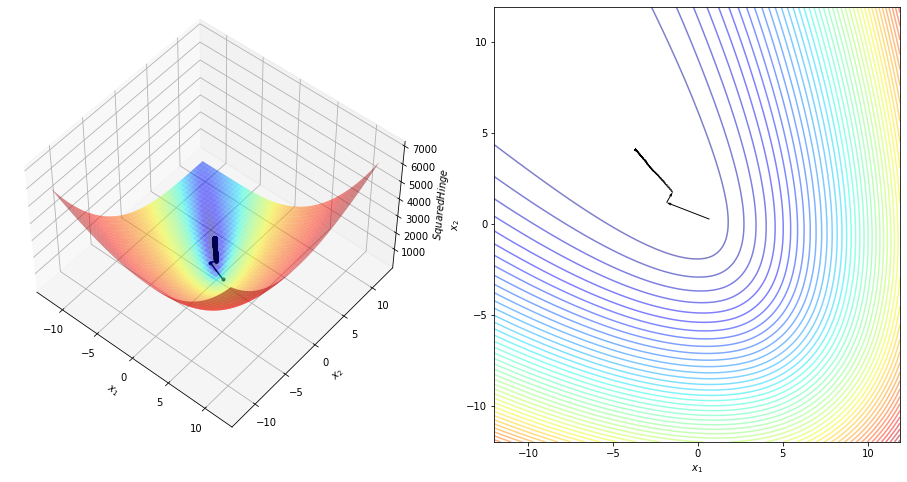

In [47]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.1),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_squared_hinge_loss.png')

In [48]:
custom_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
custom_primal_svc_squared_hinge_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
sgd,1,0.827042,0.977518,0.980100,11,6
sgd,10,0.827676,0.982531,0.985075,6,4
sgd,100,0.676569,0.985019,0.980100,4,1


In [49]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='squared_hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [50]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
liblinear,1,0.001691,0.964987,0.969923,24,13
liblinear,10,0.002881,0.964987,0.974974,19,11
liblinear,100,0.003331,0.962500,0.969998,18,10


In [52]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results, ignore_index=True)
primal_svc_squared_hinge_cv_results.sort_values(['C', 'solver'], inplace=True)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_svc_squared_hinge.tex', index=False)
primal_svc_squared_hinge_cv_results.style.hide_index()

solver,C,fit_time,train_accuracy,val_accuracy,nr_train_sv,nr_val_sv
liblinear,1,0.001691,0.964987,0.969923,24,13
sgd,1,0.827042,0.977518,0.980100,11,6
liblinear,10,0.002881,0.964987,0.974974,19,11
sgd,10,0.827676,0.982531,0.985075,6,4
liblinear,100,0.003331,0.962500,0.969998,18,10
sgd,100,0.676569,0.985019,0.980100,4,1
